In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load diabetes dataset
from sklearn.datasets import load_diabetes


# Load dataset
diabetes_data = load_diabetes(as_frame=True, scaled=False)

# Create Data Frame
df = diabetes_data.frame

In [2]:
# Print the value range of ΒΜΙ
print("BMI range:", df["bmi"].min(), "-", df["bmi"].max())

BMI range: 18.0 - 42.2


In [3]:
# Check for missing (NaN) values in the dataset
print(df.isnull().sum())
# Remove rows with missing values
df = df.dropna()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


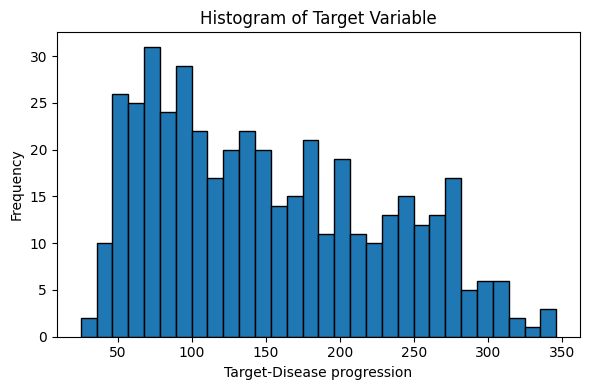

In [4]:
# Histogram of the "target" variable
plt.figure(figsize=(6, 4))
plt.hist(df["target"], bins=30, edgecolor="black")
plt.title("Histogram of Target Variable")
plt.xlabel("Target-Disease progression")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Separate features and target
X = df.drop(columns=["target"])
y = df["target"]
# Min-Max scaling will be applied inside each fold

In [6]:
# Set a fixed random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
from sklearn.model_selection import KFold

# Configure K-Fold cross validation with 6 folds and fixed seed
kf = KFold(
    n_splits=6,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [8]:
# Create a list to store the data
csv_data = []
# Append header row
csv_data.append(["Model", "Set", "Fold",\
 "Max_n", "RMSE_n", "MAE_n", "MAPE_n",\
 "Max", "RMSE", "MAE", "MAPE"])


Random Forest | Fold 1


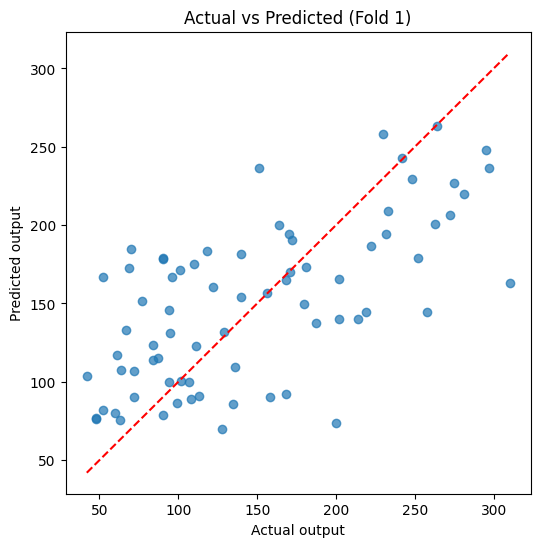

SHAP explainability | Fold 1


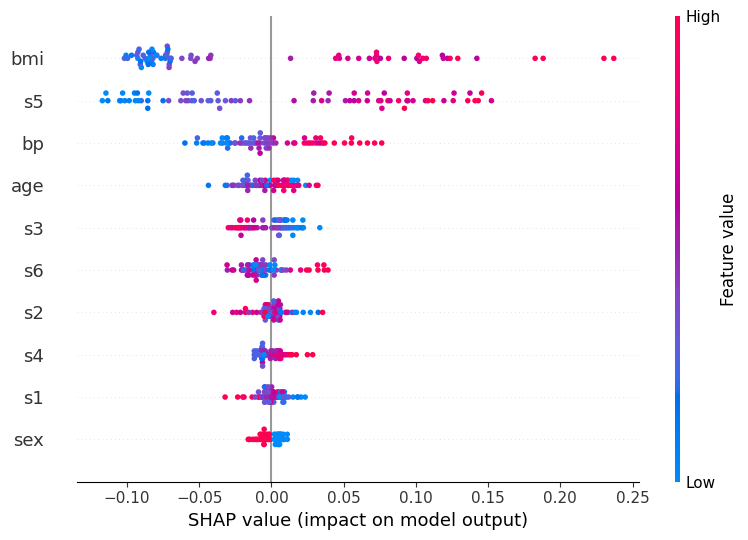

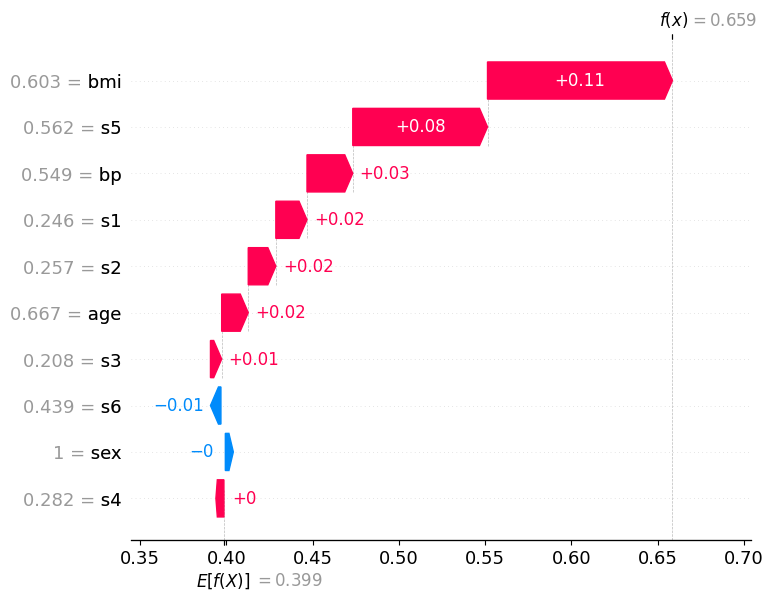

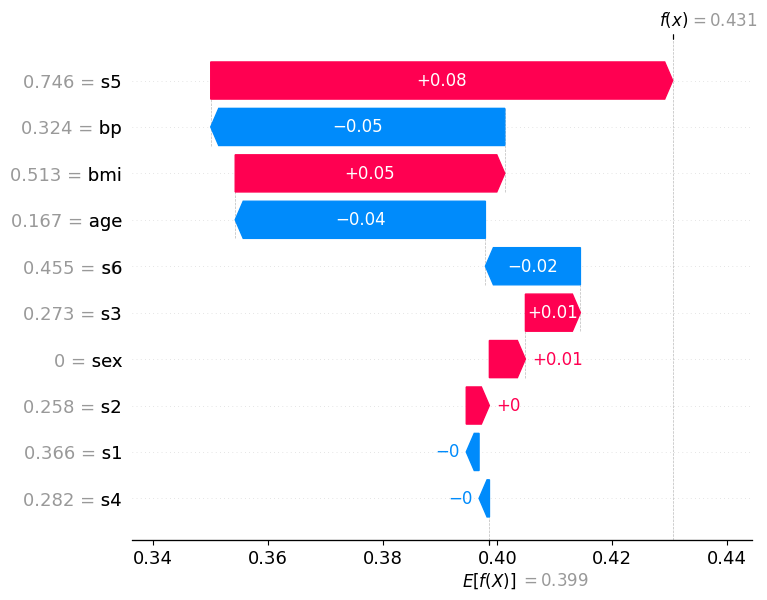


Random Forest | Fold 2


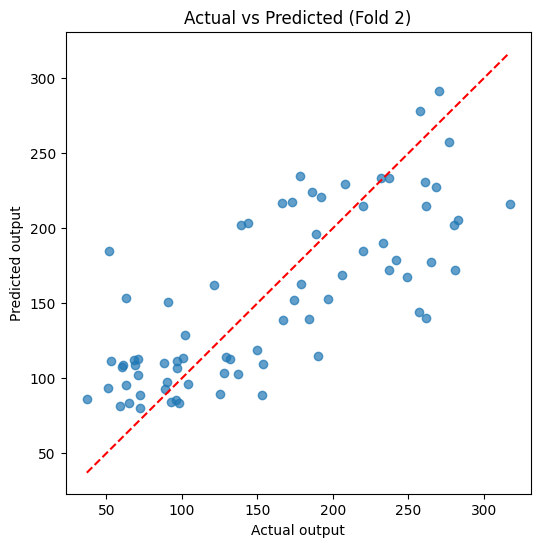

SHAP explainability | Fold 2


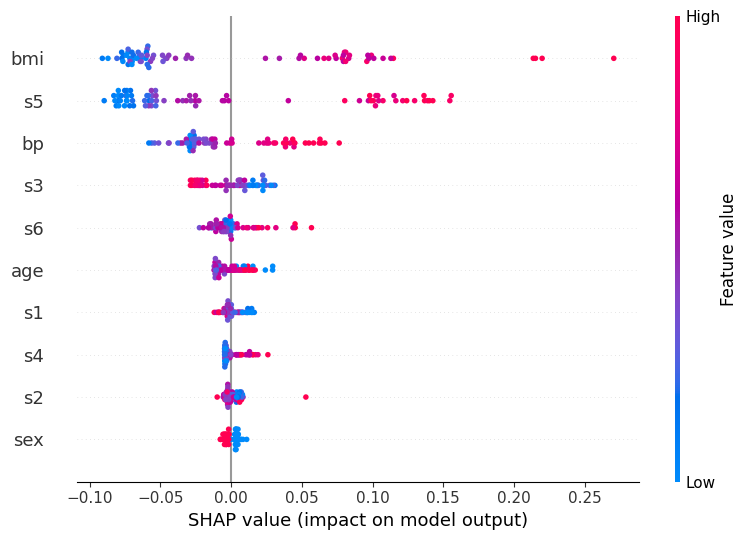

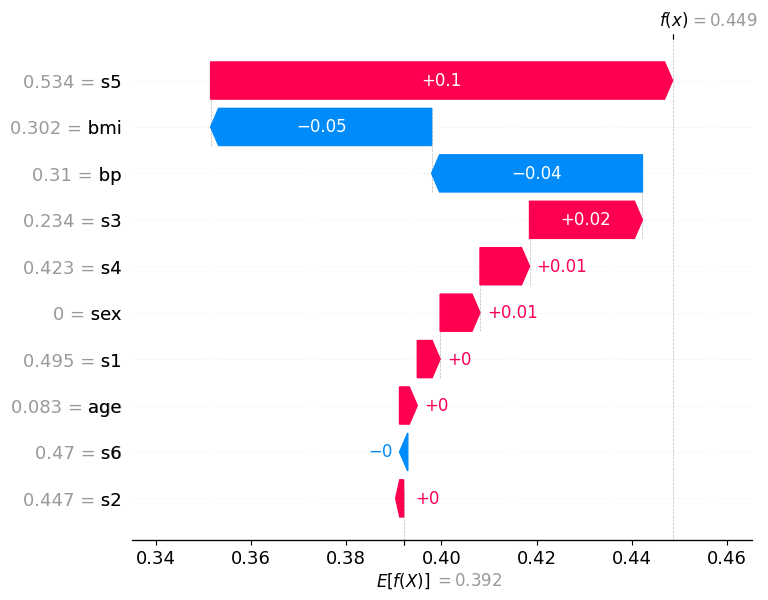

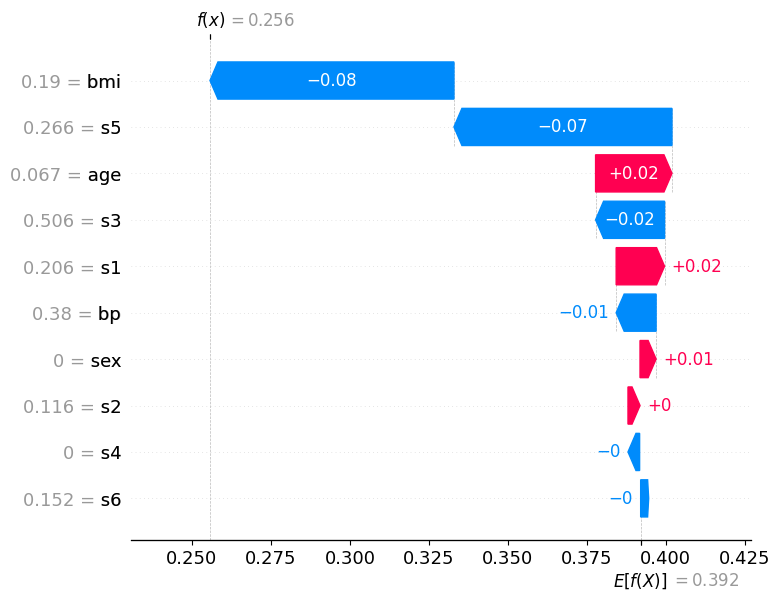


Random Forest | Fold 3


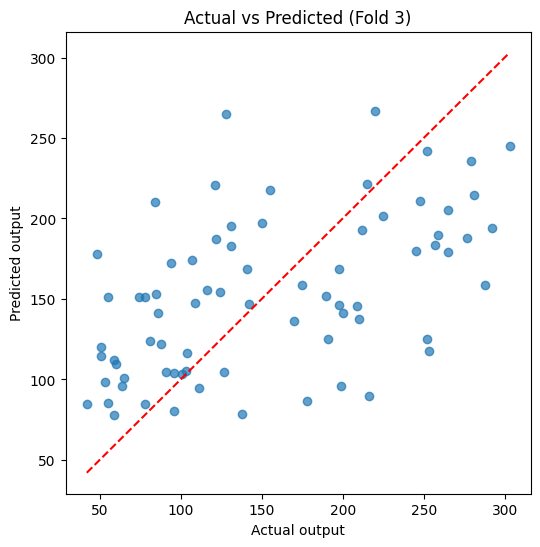

SHAP explainability | Fold 3


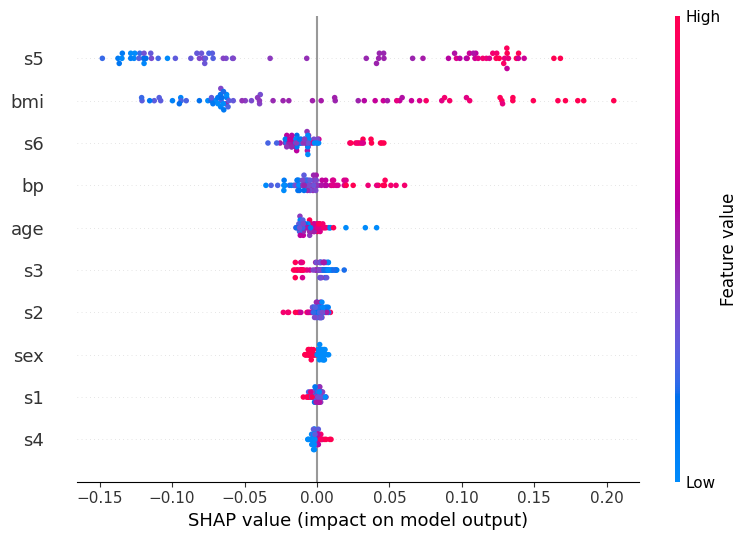

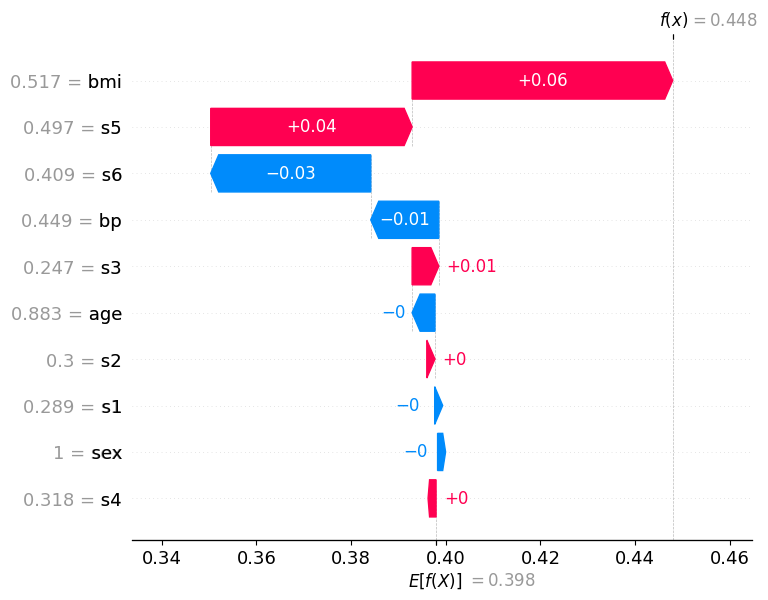

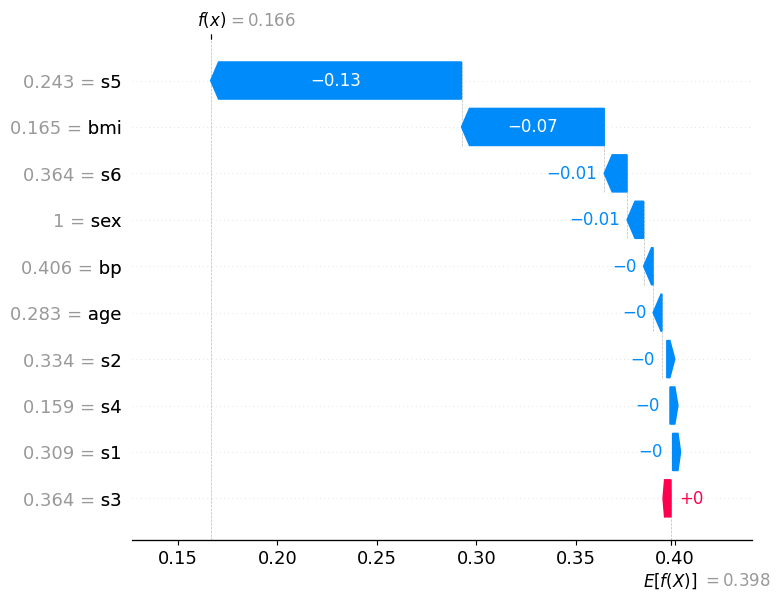


Random Forest | Fold 4


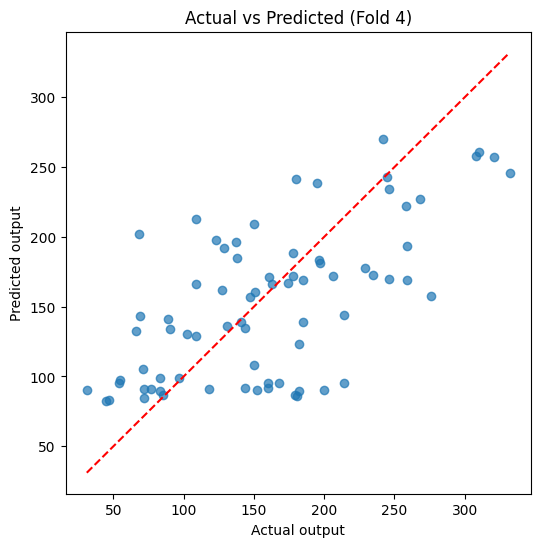

SHAP explainability | Fold 4


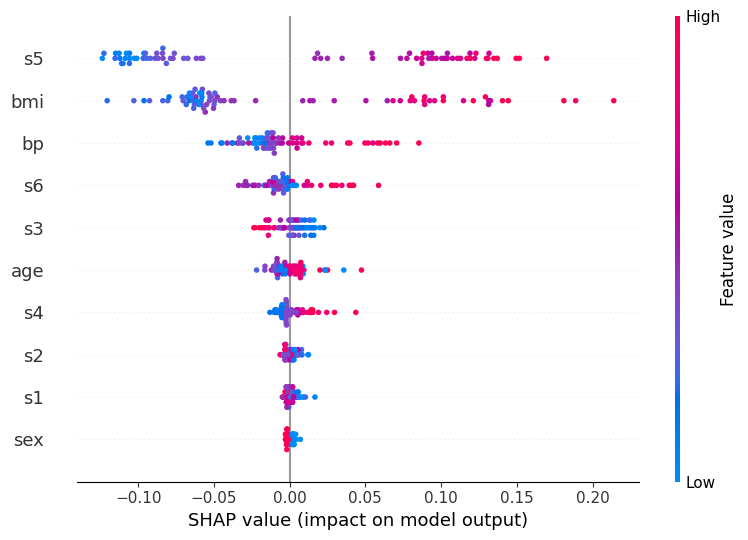

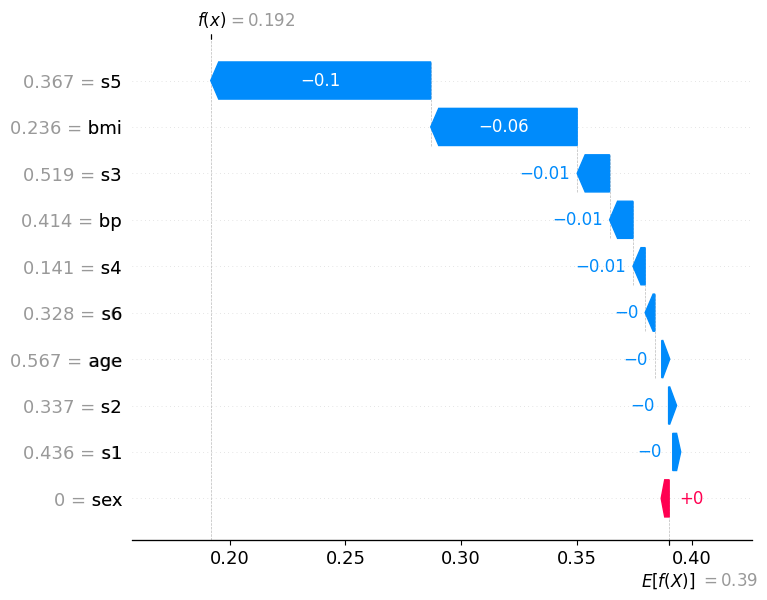

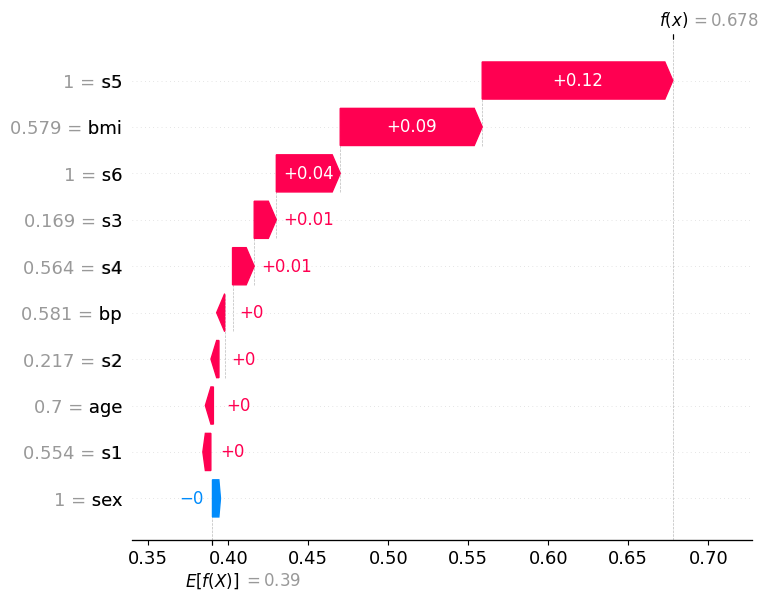


Random Forest | Fold 5


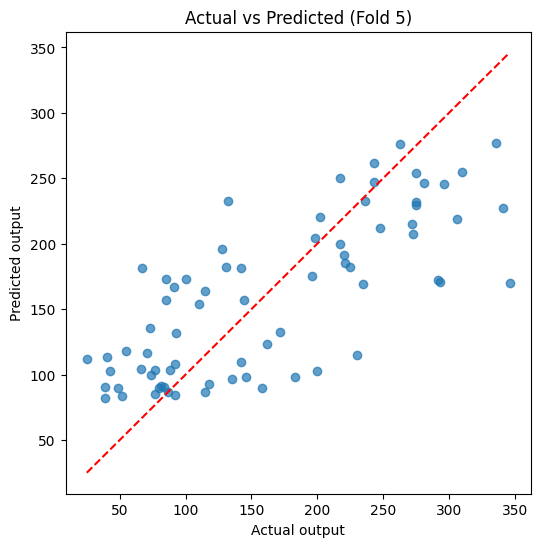

SHAP explainability | Fold 5


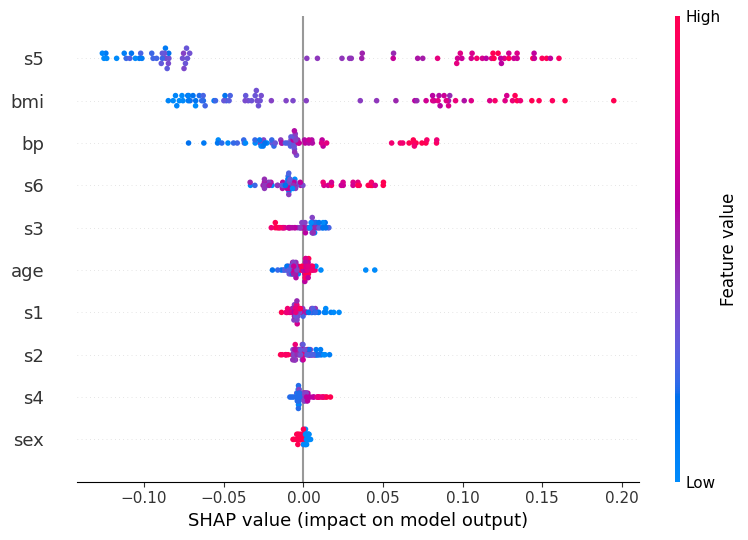

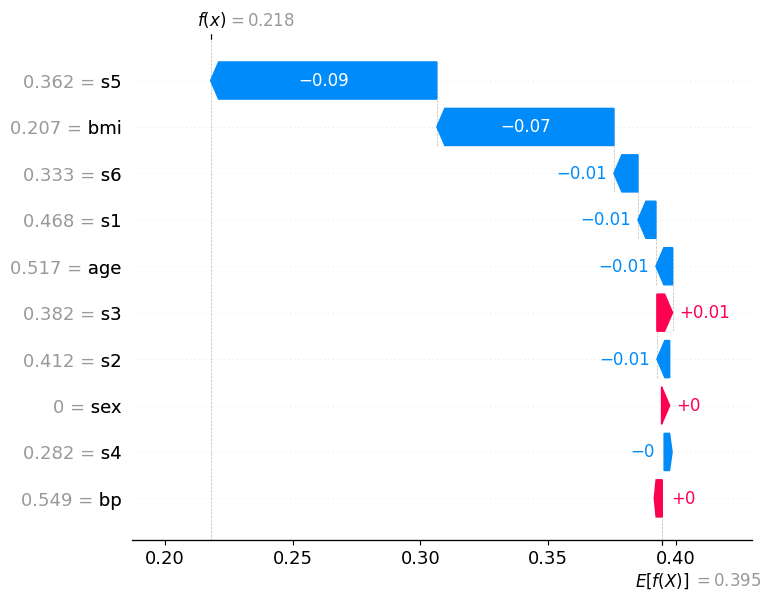

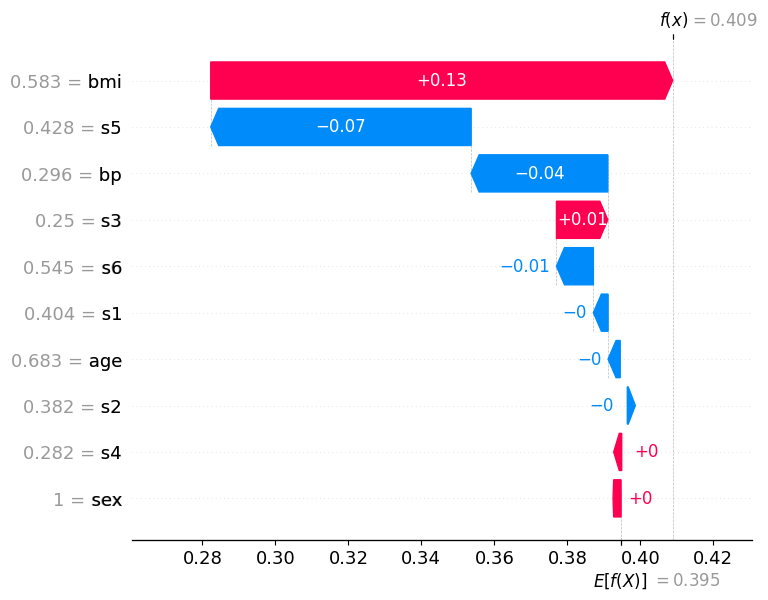


Random Forest | Fold 6


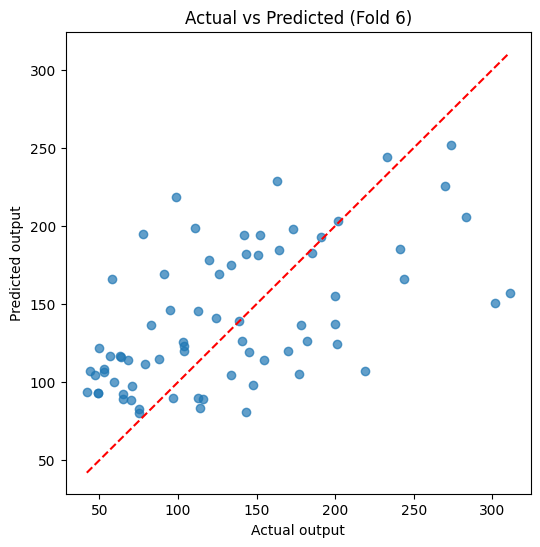

SHAP explainability | Fold 6


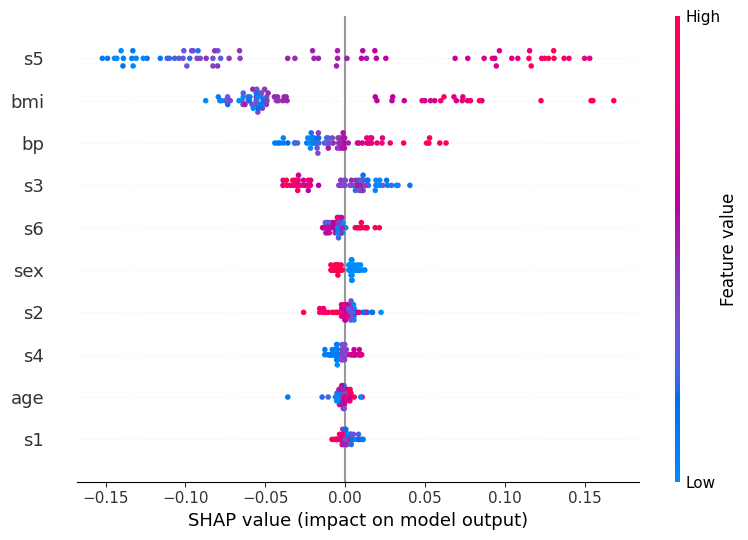

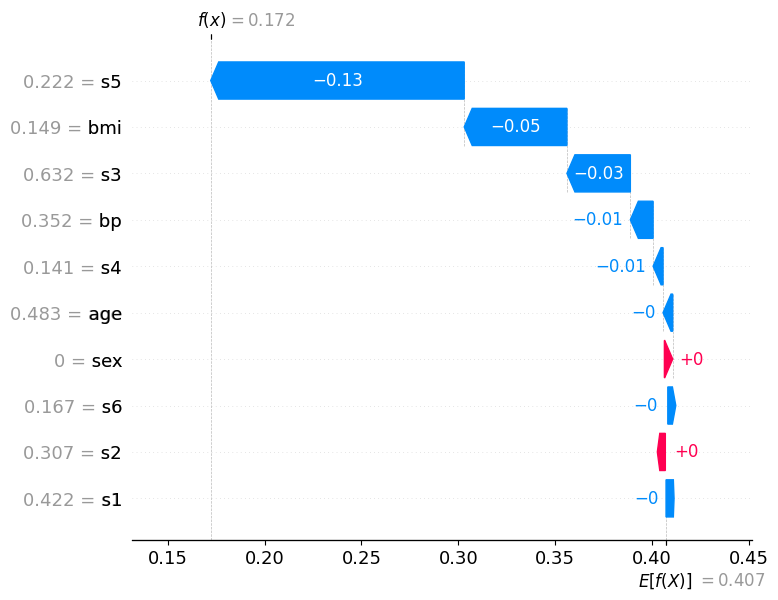

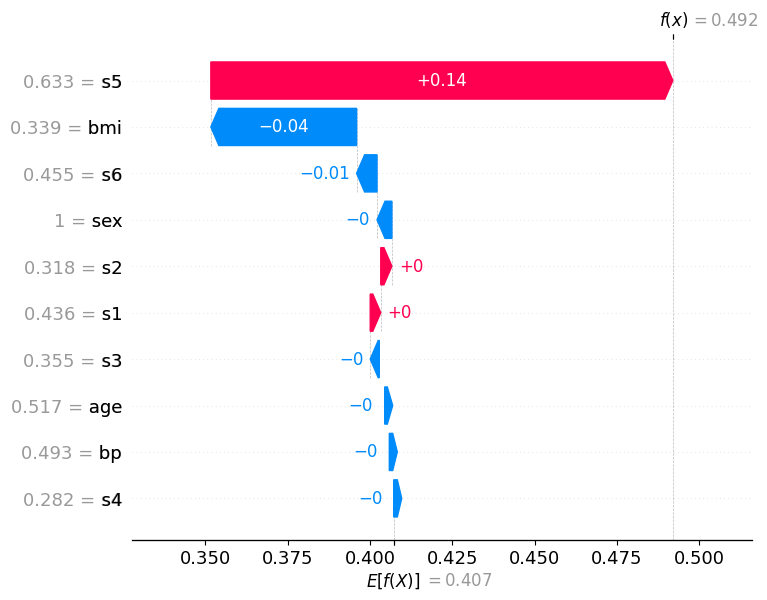

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 9. (Random Forest)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):

    print(f"\nRandom Forest | Fold {fold}")

    # 9a.
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    y_test = scaler_y.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    # 9b. RandomizedSearchCV

    rf = RandomForestRegressor(random_state=RANDOM_SEED)

    param_dist = {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    search = RandomizedSearchCV(
        rf,
        param_dist,
        n_iter=5,
        cv=3,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # 9c. Predict train and test set

    y_train_pred_scaled = best_model.predict(X_train)
    y_test_pred_scaled  = best_model.predict(X_test)

    # 9d. Denormalizition

    y_train_true = scaler_y.inverse_transform(
        y_train.reshape(-1, 1)
    ).ravel()

    y_test_true = scaler_y.inverse_transform(
        y_test.reshape(-1, 1)
    ).ravel()

    y_train_pred = scaler_y.inverse_transform(
        y_train_pred_scaled.reshape(-1, 1)
    ).ravel()

    y_test_pred = scaler_y.inverse_transform(
        y_test_pred_scaled.reshape(-1, 1)
    ).ravel()

    # 9e. Calculate error metrics

    # Train
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    mae_train  = mean_absolute_error(y_train_true, y_train_pred)
    max_train  = max_error(y_train_true, y_train_pred)
    mape_train = np.mean(
        np.abs((y_train_true - y_train_pred) / y_train_true)
    ) * 100


    #Test

    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test  = mean_absolute_error(y_test_true, y_test_pred)
    max_test  = max_error(y_test_true, y_test_pred)
    mape_test = np.mean(
        np.abs((y_test_true - y_test_pred) / y_test_true)
    ) * 100

    # 9f. Actual vs Predicted plot

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_true, y_test_pred, alpha=0.7)
    plt.plot(
        [y_test_true.min(), y_test_true.max()],
        [y_test_true.min(), y_test_true.max()],
        "r--"
    )
    plt.xlabel("Actual output")
    plt.ylabel("Predicted output")
    plt.title(f"Actual vs Predicted (Fold {fold})")
    plt.show()

    # 9g. Append

    #Train
    csv_data.append([
        "RandomForest", "Train", fold,
        max_train, rmse_train, mae_train, mape_train,
        max_train, rmse_train, mae_train, mape_train
    ])

    #Test
    csv_data.append([
        "RandomForest", "Test", fold,
        max_test, rmse_test, mae_test, mape_test,
        max_test, rmse_test, mae_test, mape_test
    ])

    # 9h. SHAP (summary plot and 2 waterfall plots)

    print(f"SHAP explainability | Fold {fold}")

    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP summary plot
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=X.columns
    )

    # SHAP waterfall plots
    for i in range(2):
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values[i],
                base_values=explainer.expected_value,
                data=X_test[i],
                feature_names=X.columns
            )
        )


Gaussian Process Regression | Fold 1


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


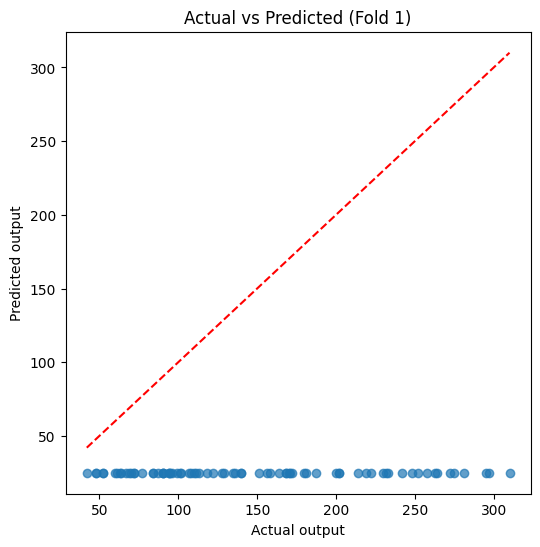

SHAP explainability | Fold 1


  0%|          | 0/20 [00:00<?, ?it/s]

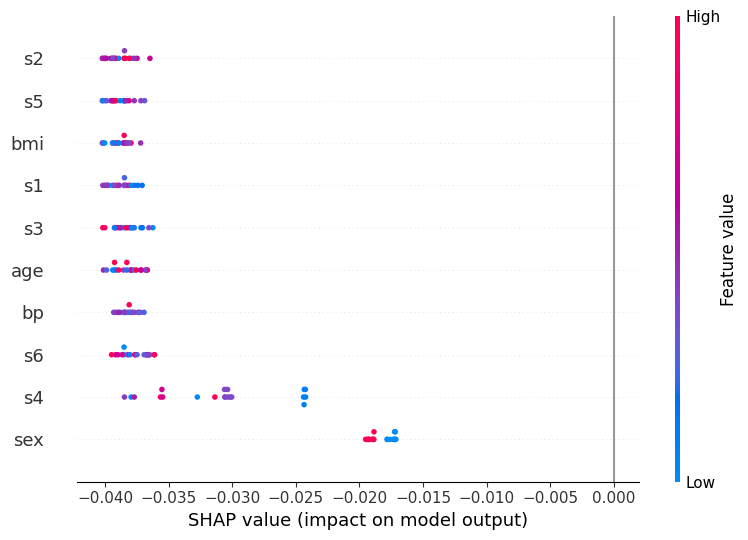

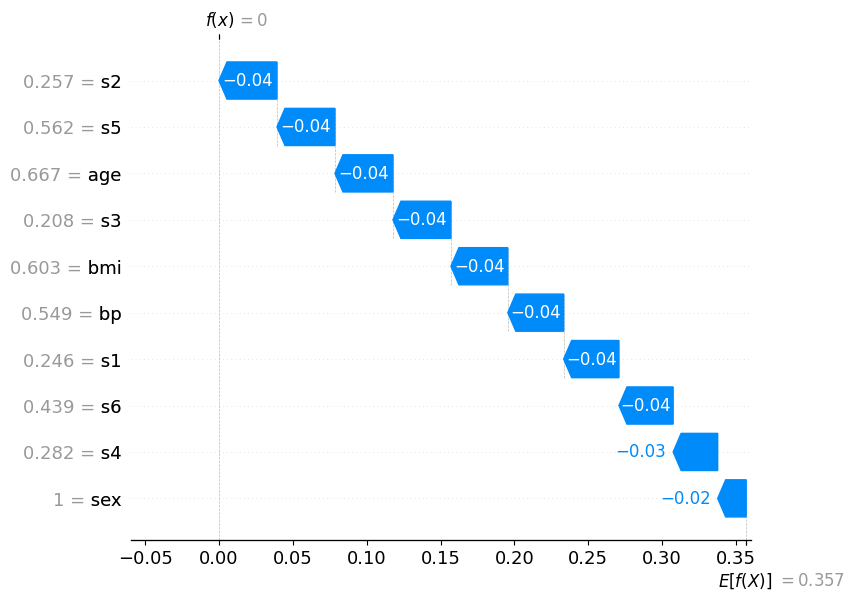

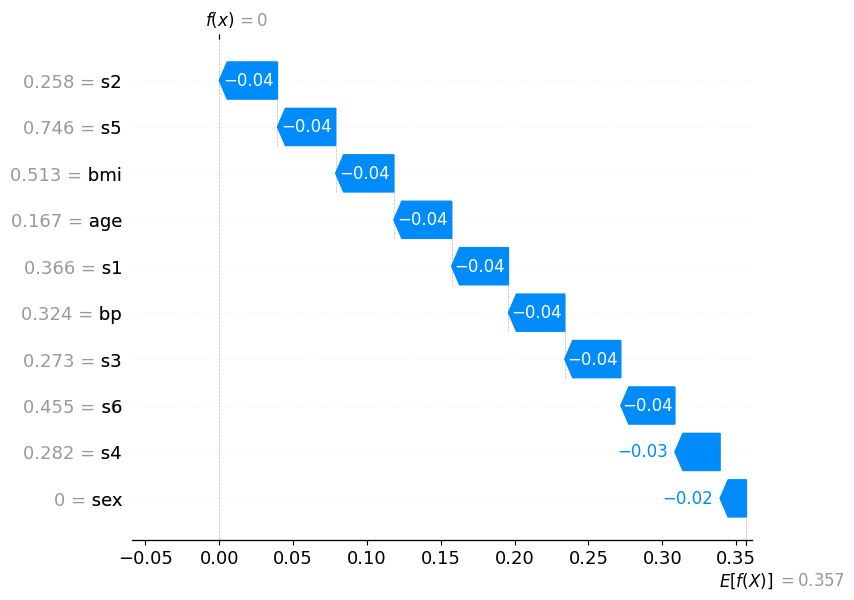


Gaussian Process Regression | Fold 2


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


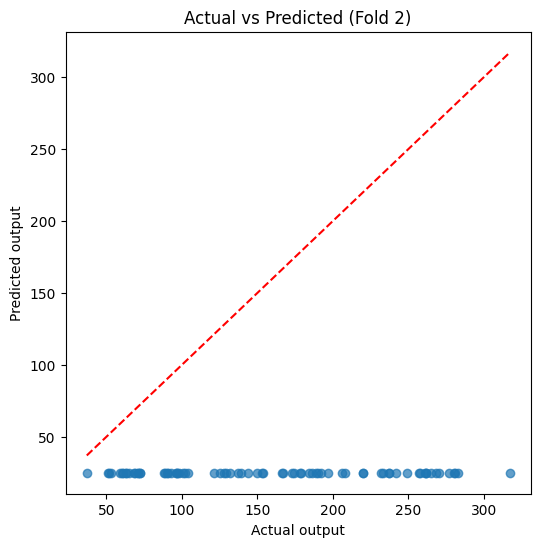

SHAP explainability | Fold 2


  0%|          | 0/20 [00:00<?, ?it/s]

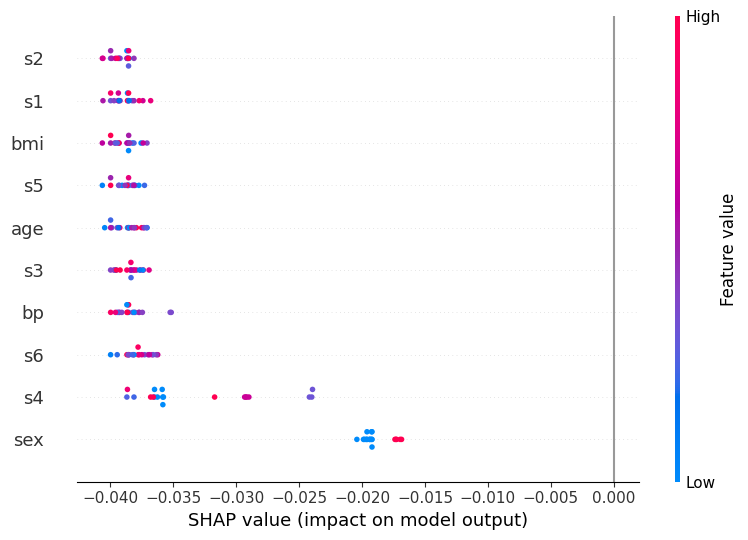

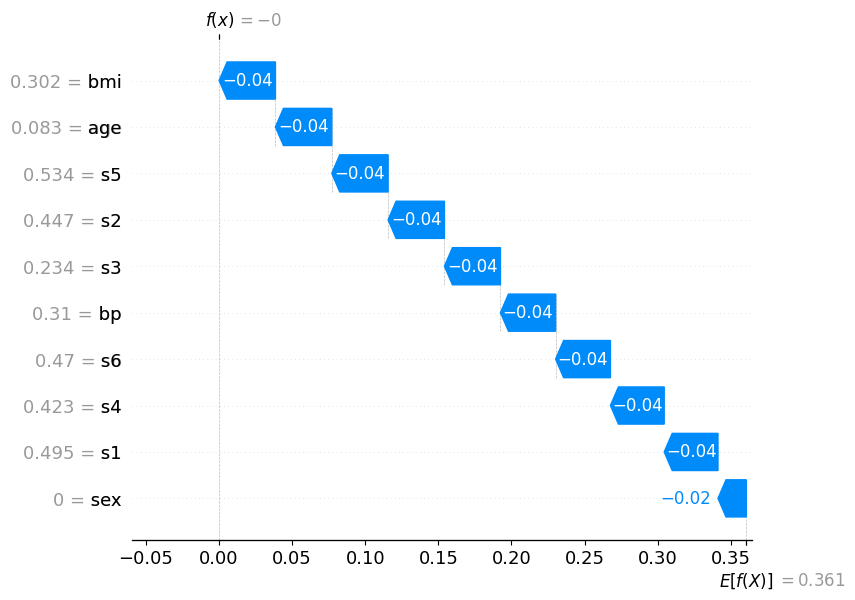

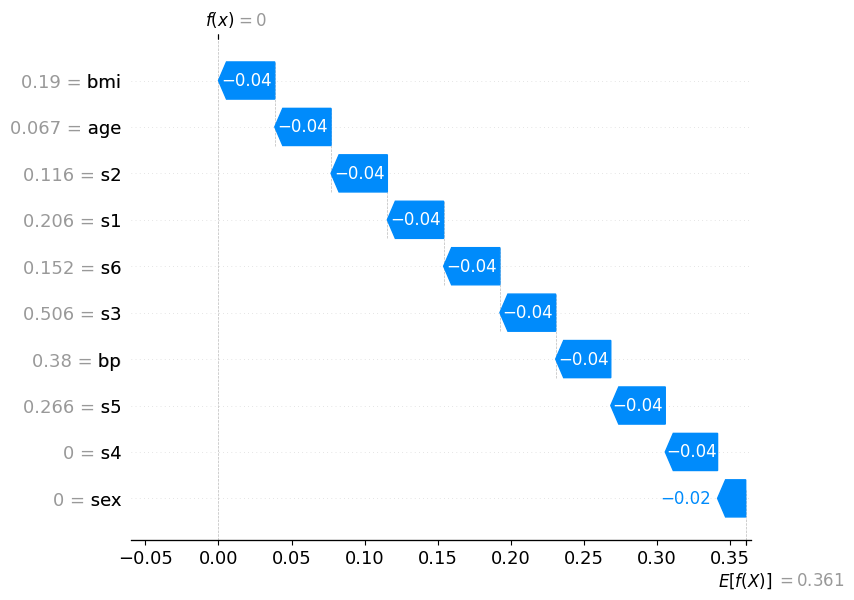


Gaussian Process Regression | Fold 3


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


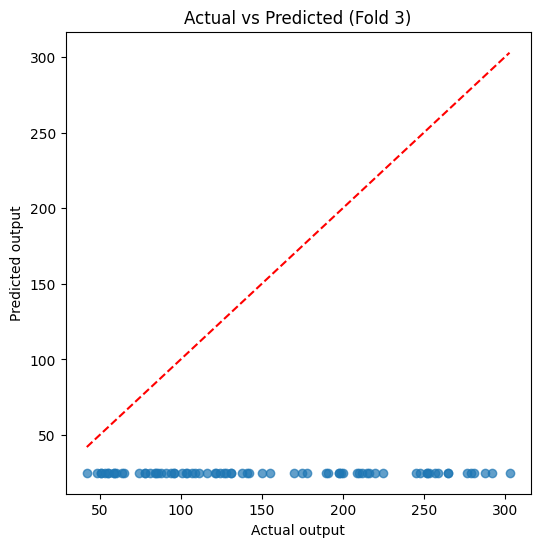

SHAP explainability | Fold 3


  0%|          | 0/20 [00:00<?, ?it/s]

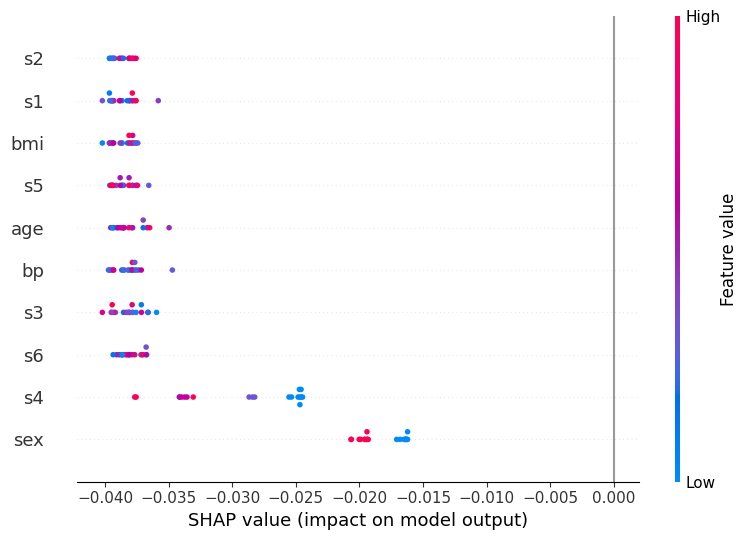

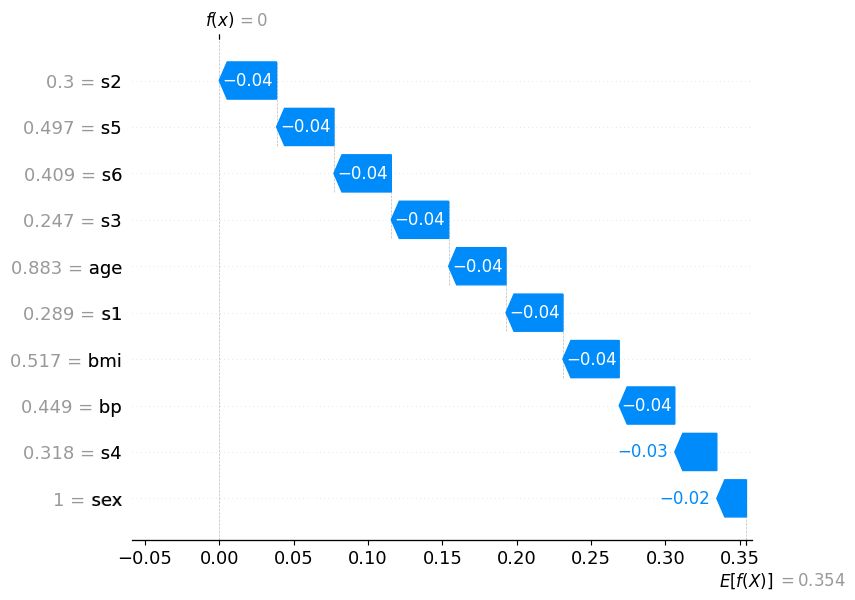

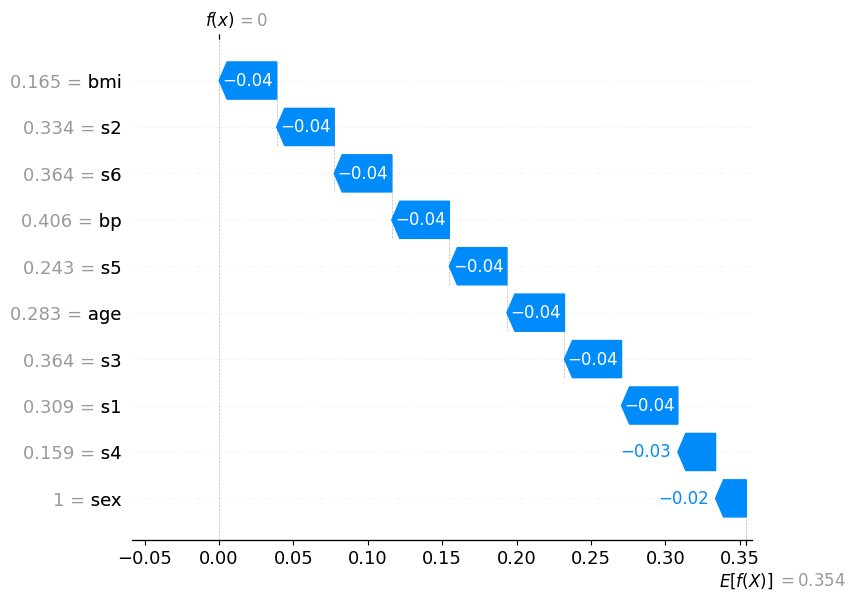


Gaussian Process Regression | Fold 4


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


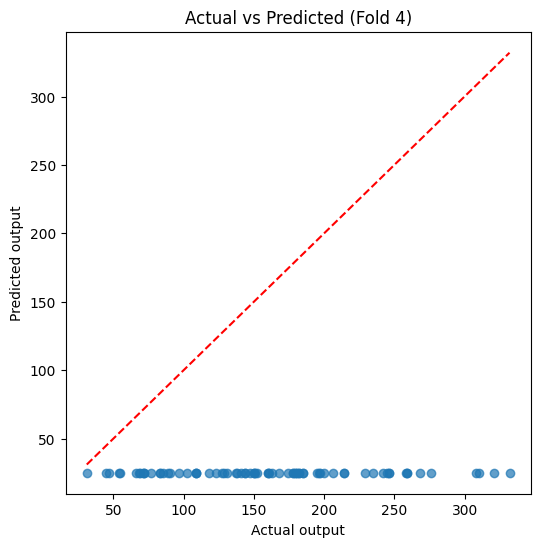

SHAP explainability | Fold 4


  0%|          | 0/20 [00:00<?, ?it/s]

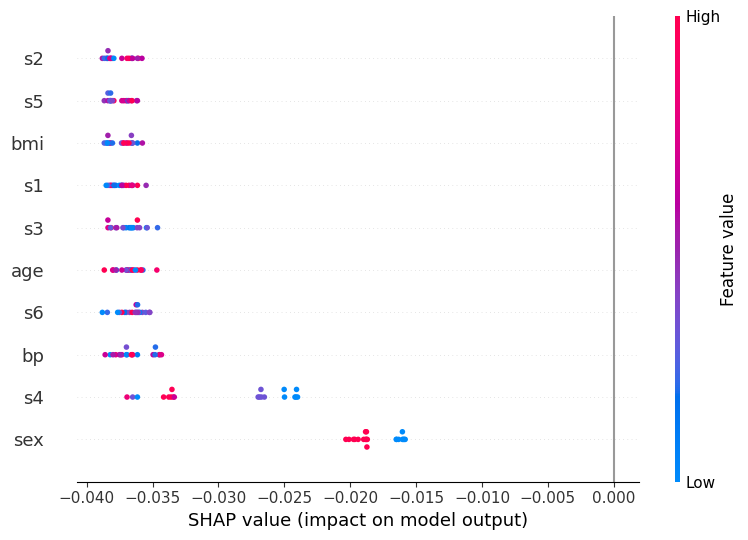

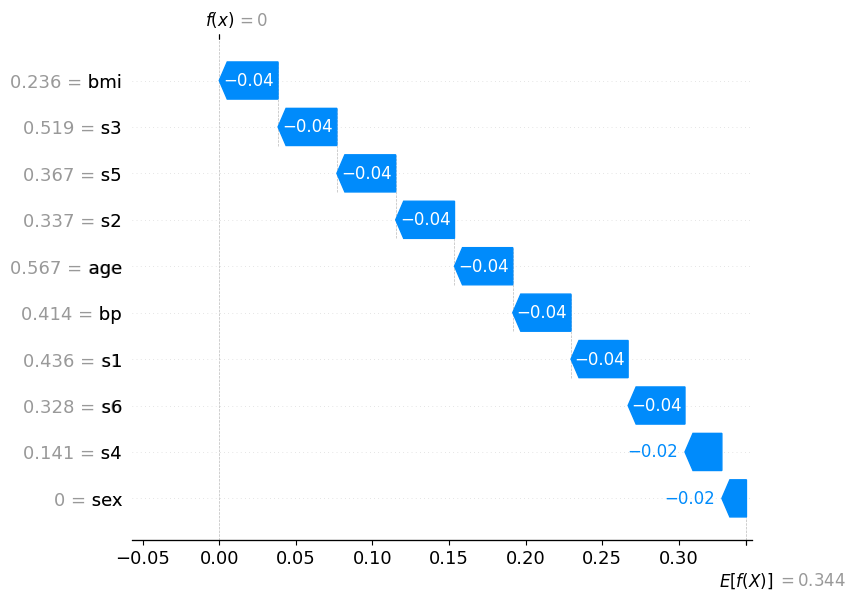

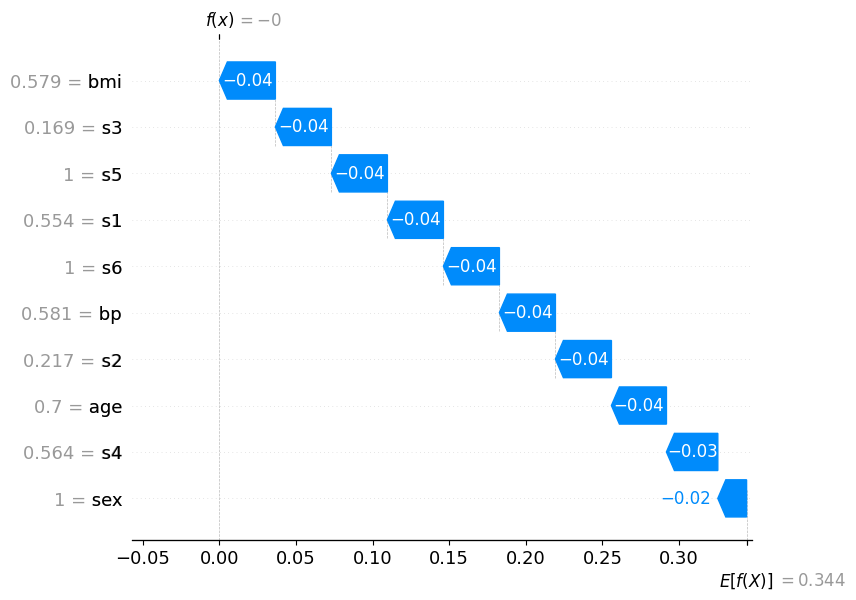


Gaussian Process Regression | Fold 5


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


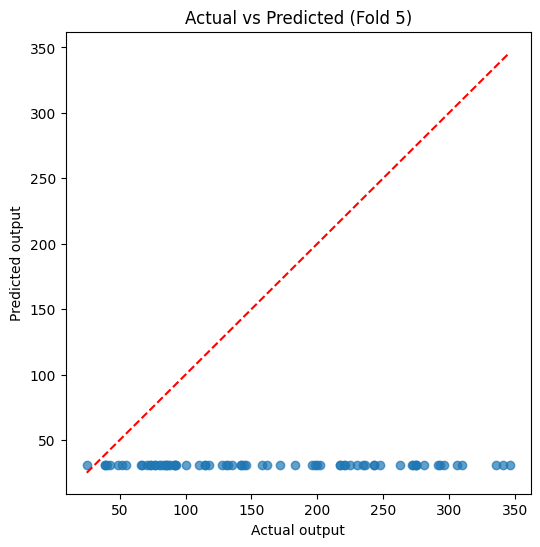

SHAP explainability | Fold 5


  0%|          | 0/20 [00:00<?, ?it/s]

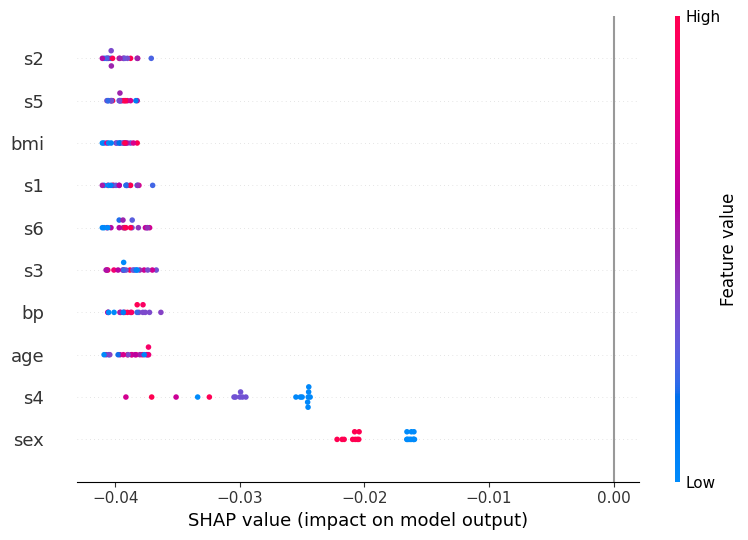

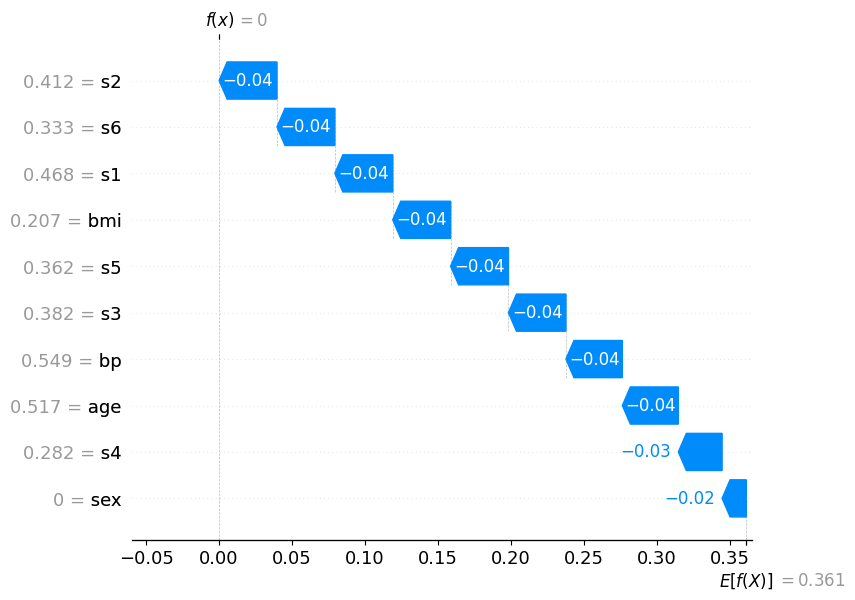

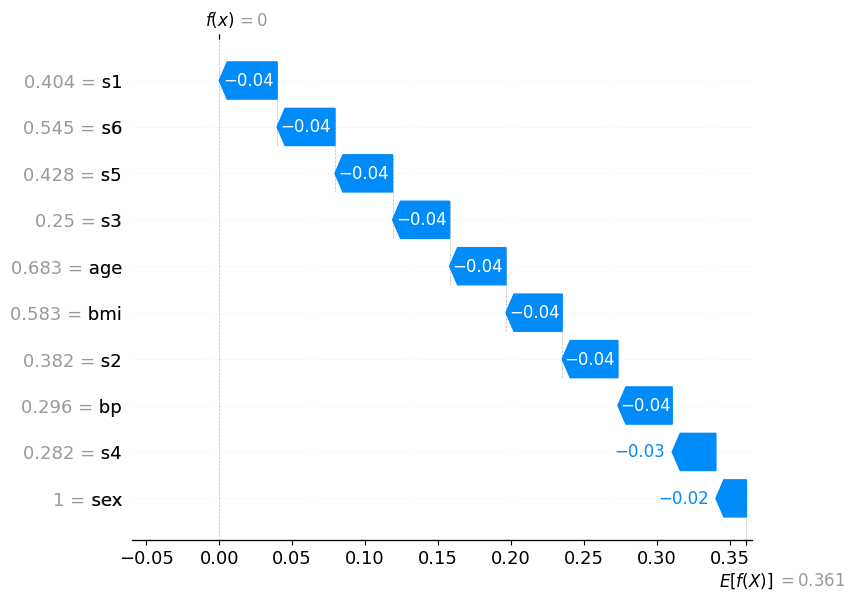


Gaussian Process Regression | Fold 6


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


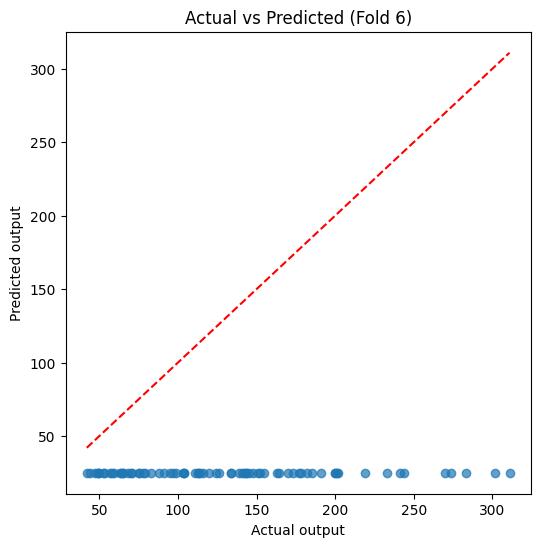

SHAP explainability | Fold 6


  0%|          | 0/20 [00:00<?, ?it/s]

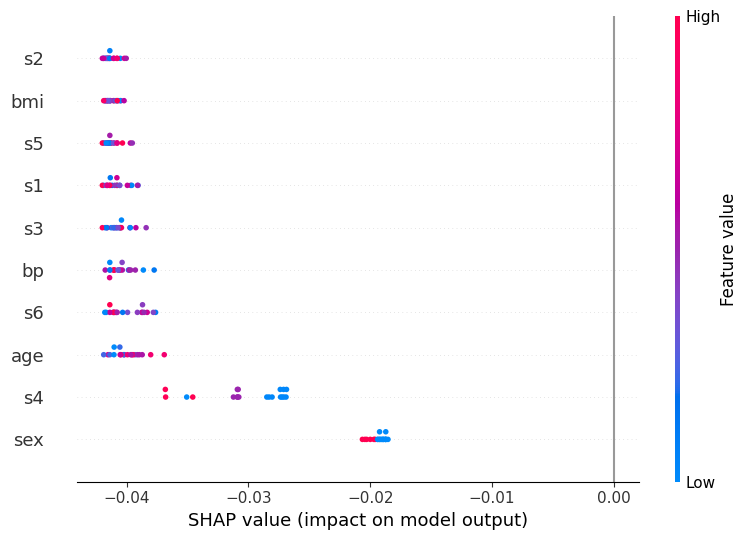

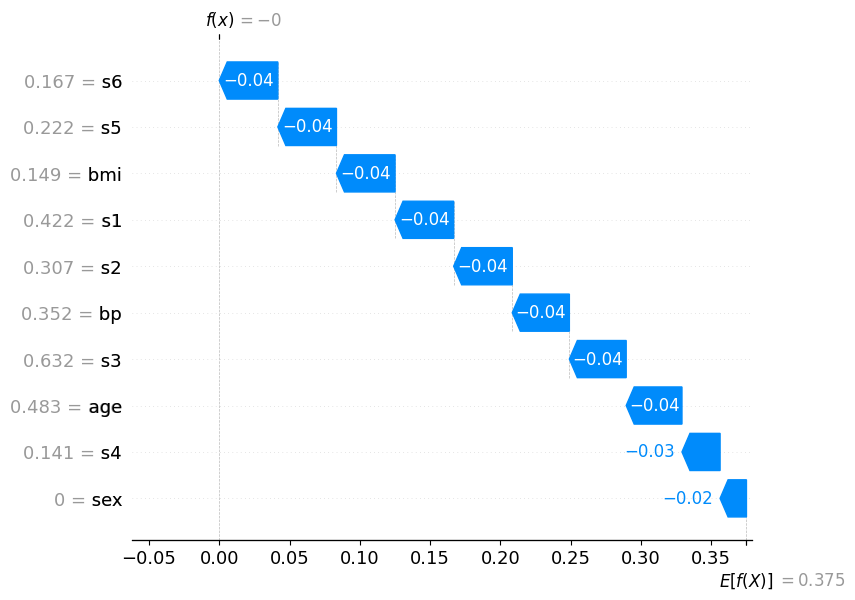

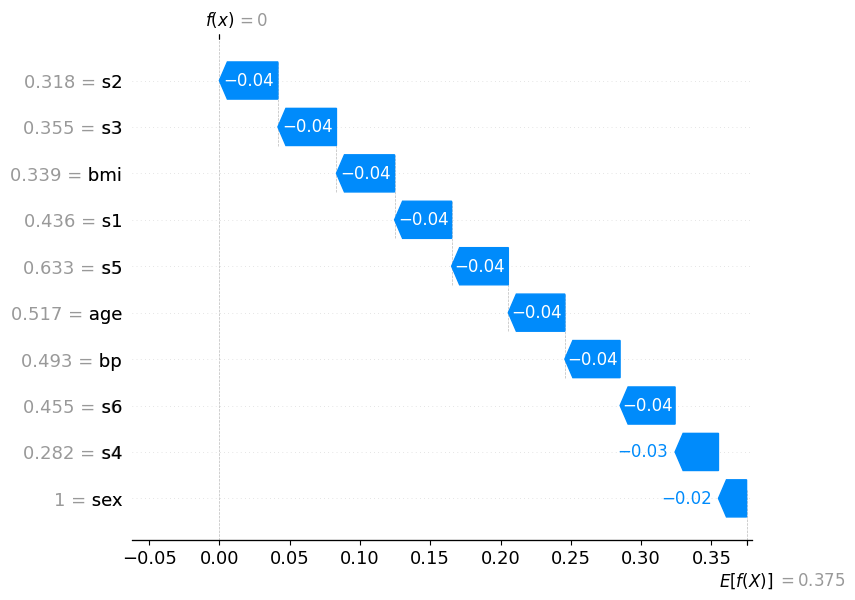

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 9. (Gaussian Process Regression)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):

    print(f"\nGaussian Process Regression | Fold {fold}")

    # 9a.
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    y_test = scaler_y.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    # 9b. RandomizedSearchCV
    kernel = RBF()

    gpr = GaussianProcessRegressor(
        kernel=kernel,
        random_state=RANDOM_SEED
    )

    gpr.fit(X_train, y_train)
    best_model = gpr

    # 9c. Predict train and test set
    y_train_pred_scaled = best_model.predict(X_train)
    y_test_pred_scaled  = best_model.predict(X_test)

    # 9d. Denormalizition
    y_train_true = scaler_y.inverse_transform(
        y_train.reshape(-1, 1)
    ).ravel()

    y_test_true = scaler_y.inverse_transform(
        y_test.reshape(-1, 1)
    ).ravel()

    y_train_pred = scaler_y.inverse_transform(
        y_train_pred_scaled.reshape(-1, 1)
    ).ravel()

    y_test_pred = scaler_y.inverse_transform(
        y_test_pred_scaled.reshape(-1, 1)
    ).ravel()

    # 9e. Calculate error metrics

    #Train

    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    mae_train  = mean_absolute_error(y_train_true, y_train_pred)
    max_train  = max_error(y_train_true, y_train_pred)
    mape_train = np.mean(
        np.abs((y_train_true - y_train_pred) / y_train_true)
    ) * 100

    #Test

    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test  = mean_absolute_error(y_test_true, y_test_pred)
    max_test  = max_error(y_test_true, y_test_pred)
    mape_test = np.mean(
        np.abs((y_test_true - y_test_pred) / y_test_true)
    ) * 100

    # 9f. Actual vs Predicted plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_true, y_test_pred, alpha=0.7)
    plt.plot(
        [y_test_true.min(), y_test_true.max()],
        [y_test_true.min(), y_test_true.max()],
        "r--"
    )
    plt.xlabel("Actual output")
    plt.ylabel("Predicted output")
    plt.title(f"Actual vs Predicted (Fold {fold})")
    plt.show()

    # 9g. Append

    #Train
    csv_data.append([
        "GaussianProcess", "Train", fold,
        max_train, rmse_train, mae_train, mape_train,
        max_train, rmse_train, mae_train, mape_train
    ])

    #Test
    csv_data.append([
        "GaussianProcess", "Test", fold,
        max_test, rmse_test, mae_test, mape_test,
        max_test, rmse_test, mae_test, mape_test
    ])

    # 9h. SHAP (summary plot and 2 waterfall plots)
    print(f"SHAP explainability | Fold {fold}")

    explainer = shap.KernelExplainer(
        best_model.predict,
        X_train[:50]
    )

    shap_values = explainer.shap_values(X_test[:20])

    shap.summary_plot(
        shap_values,
        X_test[:20],
        feature_names=X.columns
    )

    for i in range(2):
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values[i],
                base_values=explainer.expected_value,
                data=X_test[i],
                feature_names=X.columns
            )
        )


Support Vector Regression | Fold 1


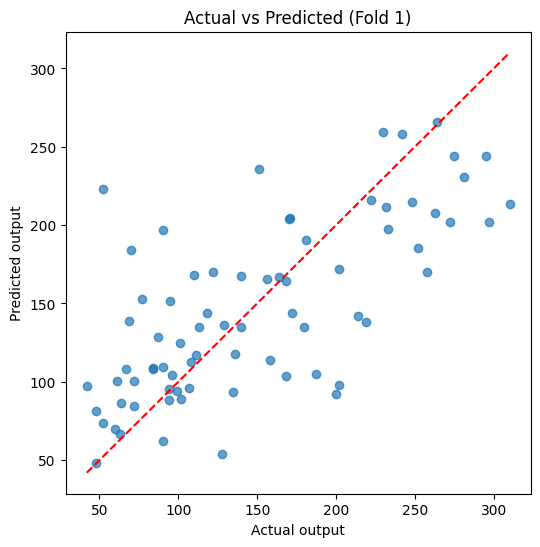


Support Vector Regression | Fold 2


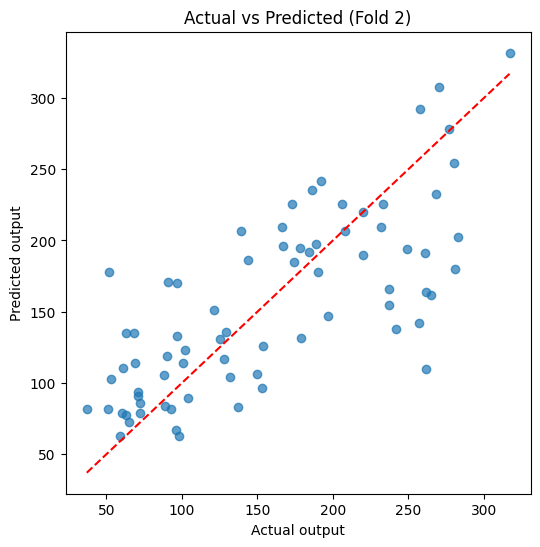


Support Vector Regression | Fold 3


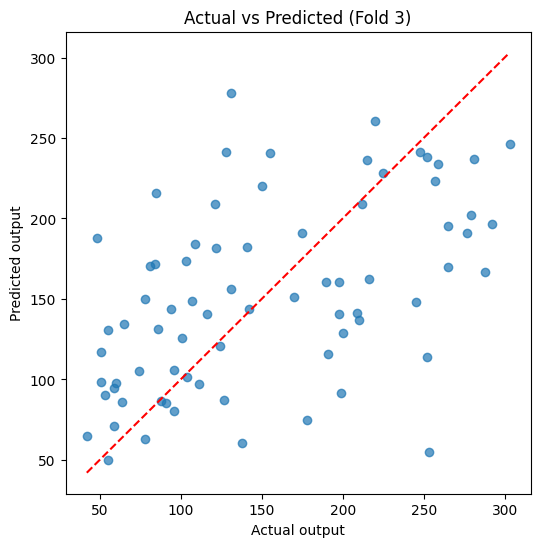


Support Vector Regression | Fold 4


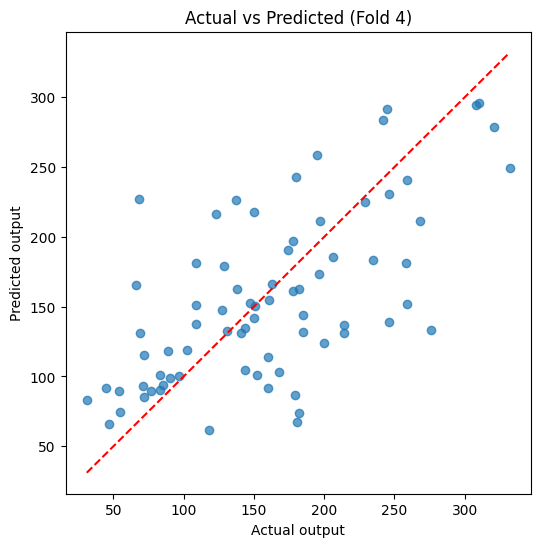


Support Vector Regression | Fold 5


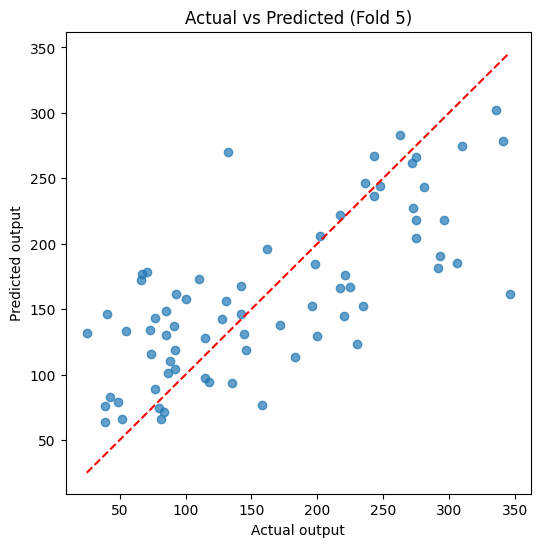


Support Vector Regression | Fold 6


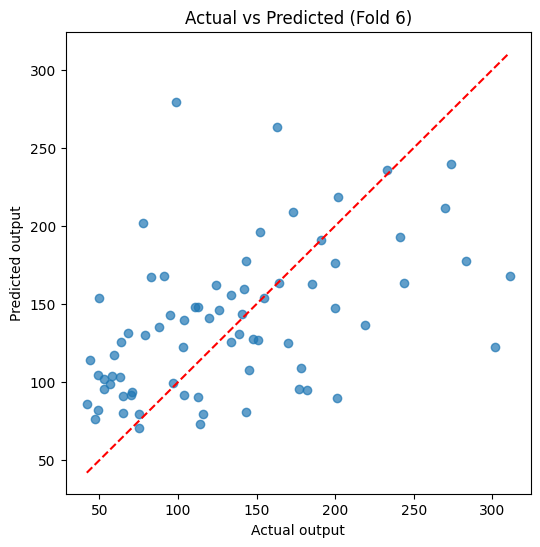

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import matplotlib.pyplot as plt

# 9. (Support Vector Regression)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):

    print(f"\nSupport Vector Regression | Fold {fold}")

    # 9a.
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    y_test = scaler_y.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    # 9b. RandomizedSearchCV
    svr = SVR(kernel="rbf")
    best_model = svr.fit(X_train, y_train)

    # 9c. Predict train and test set
    y_train_pred_scaled = best_model.predict(X_train)
    y_test_pred_scaled  = best_model.predict(X_test)

    # 9d. Denormalizition
    y_train_true = scaler_y.inverse_transform(
        y_train.reshape(-1, 1)
    ).ravel()

    y_test_true = scaler_y.inverse_transform(
        y_test.reshape(-1, 1)
    ).ravel()

    y_train_pred = scaler_y.inverse_transform(
        y_train_pred_scaled.reshape(-1, 1)
    ).ravel()

    y_test_pred = scaler_y.inverse_transform(
        y_test_pred_scaled.reshape(-1, 1)
    ).ravel()

    # 9e. Calculate error metrics

    #Train

    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    mae_train  = mean_absolute_error(y_train_true, y_train_pred)
    max_train  = max_error(y_train_true, y_train_pred)
    mape_train = np.mean(
        np.abs((y_train_true - y_train_pred) / y_train_true)
    ) * 100

    #Test

    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test  = mean_absolute_error(y_test_true, y_test_pred)
    max_test  = max_error(y_test_true, y_test_pred)

    mape_test = np.mean(
        np.abs((y_test_true - y_test_pred) / y_test_true)
    ) * 100

    # 9f. Actual vs Predicted plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_true, y_test_pred, alpha=0.7)
    plt.plot(
        [y_test_true.min(), y_test_true.max()],
        [y_test_true.min(), y_test_true.max()],
        "r--"
    )
    plt.xlabel("Actual output")
    plt.ylabel("Predicted output")
    plt.title(f"Actual vs Predicted (Fold {fold})")
    plt.show()

    # 9g. Append

    #Train

    csv_data.append([
        "SVR", "Train", fold,
        max_train, rmse_train, mae_train, mape_train,
        max_train, rmse_train, mae_train, mape_train
    ])

    #Test

    csv_data.append([
        "SVR", "Test", fold,
        max_test, rmse_test, mae_test, mape_test,
        max_test, rmse_test, mae_test, mape_test
    ])


KNN Regression | Fold 1


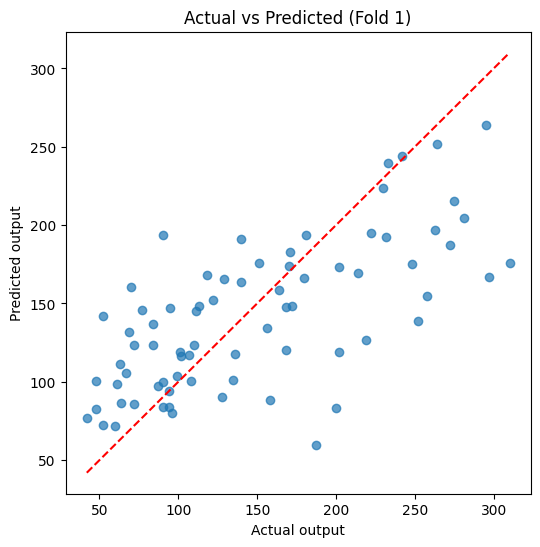


KNN Regression | Fold 2


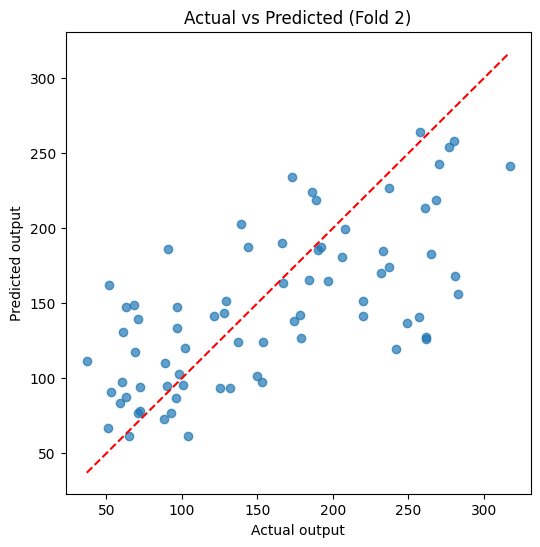


KNN Regression | Fold 3


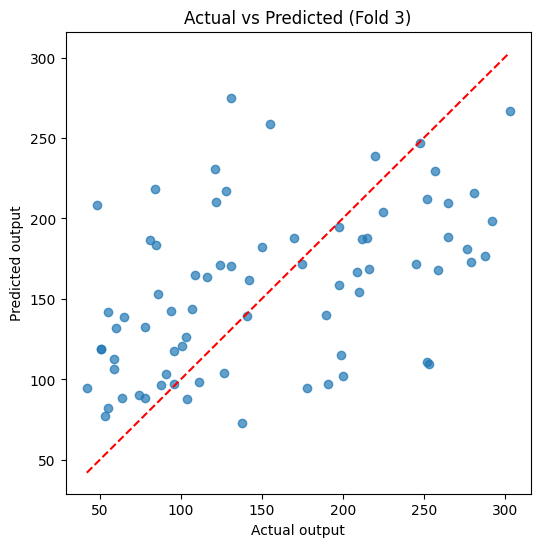


KNN Regression | Fold 4


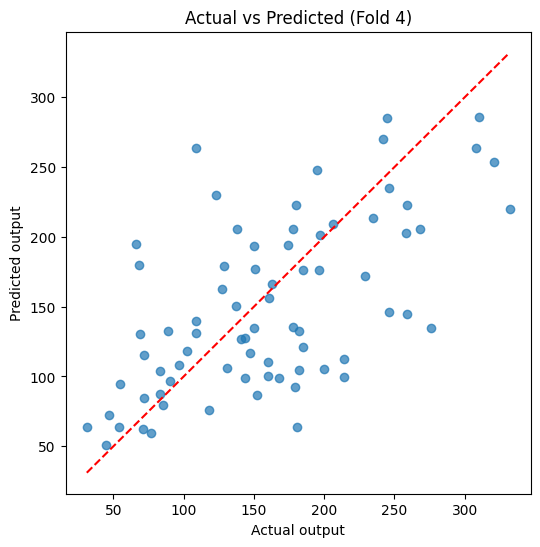


KNN Regression | Fold 5


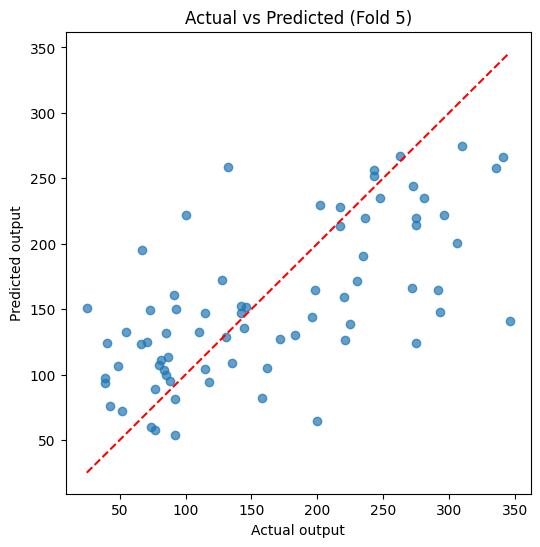


KNN Regression | Fold 6


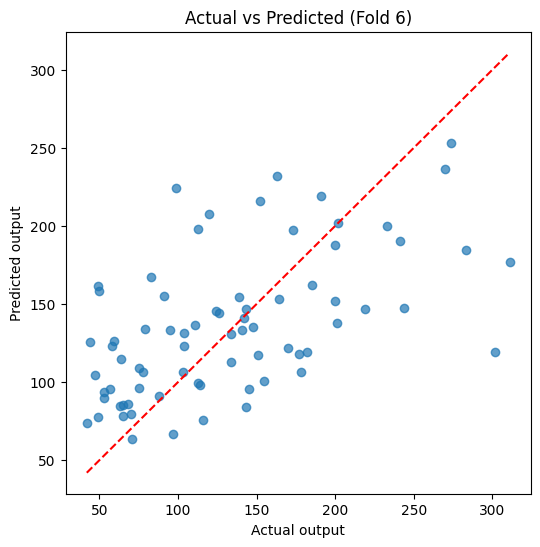

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import matplotlib.pyplot as plt

# 9. (K-Nearest Neighbors Regression)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):

    print(f"\nKNN Regression | Fold {fold}")

    # 9a.
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    y_test = scaler_y.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    # 9b. RandomizedSearchCV
    knn = KNeighborsRegressor(n_neighbors=5)
    best_model = knn.fit(X_train, y_train)

    # 9c. Predict train and test set
    y_train_pred_scaled = best_model.predict(X_train)
    y_test_pred_scaled  = best_model.predict(X_test)

    # 9d. Denormalizition
    y_train_true = scaler_y.inverse_transform(
        y_train.reshape(-1, 1)
    ).ravel()

    y_test_true = scaler_y.inverse_transform(
        y_test.reshape(-1, 1)
    ).ravel()

    y_train_pred = scaler_y.inverse_transform(
        y_train_pred_scaled.reshape(-1, 1)
    ).ravel()

    y_test_pred = scaler_y.inverse_transform(
        y_test_pred_scaled.reshape(-1, 1)
    ).ravel()

    # 9e. Calculate error metrics

    #Train

    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    mae_train  = mean_absolute_error(y_train_true, y_train_pred)
    max_train  = max_error(y_train_true, y_train_pred)
    mape_train = np.mean(
        np.abs((y_train_true - y_train_pred) / y_train_true)
    ) * 100

    #Test

    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test  = mean_absolute_error(y_test_true, y_test_pred)
    max_test  = max_error(y_test_true, y_test_pred)
    mape_test = np.mean(
        np.abs((y_test_true - y_test_pred) / y_test_true)
    ) * 100

    # 9f. Actual vs Predicted plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_true, y_test_pred, alpha=0.7)
    plt.plot(
        [y_test_true.min(), y_test_true.max()],
        [y_test_true.min(), y_test_true.max()],
        "r--"
    )
    plt.xlabel("Actual output")
    plt.ylabel("Predicted output")
    plt.title(f"Actual vs Predicted (Fold {fold})")
    plt.show()

    # 9g. Append

    #Train
    csv_data.append([
        "KNN", "Train", fold,
        max_train, rmse_train, mae_train, mape_train,
        max_train, rmse_train, mae_train, mape_train
    ])

    #Test
    csv_data.append([
        "KNN", "Test", fold,
        max_test, rmse_test, mae_test, mape_test,
        max_test, rmse_test, mae_test, mape_test
    ])

In [13]:
df_results = pd.DataFrame(
    csv_data[1:],
    columns=csv_data[0]
)

df_results.to_csv("regression_results.csv", index=False)

In [14]:
# Debug check, verify that each model has 6 folds for train and test
df_debug = pd.DataFrame(csv_data[1:], columns=csv_data[0])

print(df_debug.groupby(["Model", "Set"]).Fold.nunique())

Model            Set  
GaussianProcess  Test     6
                 Train    6
KNN              Test     6
                 Train    6
RandomForest     Test     6
                 Train    6
SVR              Test     6
                 Train    6
Name: Fold, dtype: int64


In [15]:
# Uncomment to download results locally
# from google.colab import files
# files.download("regression_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>